# Endothelial cells

In [ ]:
import scanpy as sc
from tidyverse.dummy import *
from sctools import pipeline
from sctools.scplotting import recolor, kneeplot_split
from sctools.de import gene_expression_to_flat_df_NEW, scanpy_DE_to_dataframe_fast, get_de_genes
from crukiopy_release.datatools import read_metadata
from crukiopy_release.colormaps import celltype_order_coarse_celltype, color_dict_diagnosis, cmap_subtypes
from crukiopy_release.datatools import fix_diagnosis, diagnosis_fix_dict

import gc
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
from sccoda.util import comp_ana as mod
from cellprop_utils import plot_patient_diagnosis

from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg')
set_matplotlib_formats('png')
from sctools.composition import clustered_heatmap_from_sccoda_CLR, compositional_pca, plot_pca_loadings

Importing tidyverse


## Create data

the original full dataset is located here:
```gsutil -m cp gs://cruk-adata-for-cellbrowser/Aug2022_adata/Atlas/Eso_Atlas.h5ad .```

In [2]:
adata = sc.read_h5ad('/home/mstrasse/TB4/Aug2022_adata/Atlas/Eso_Atlas.h5ad')

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


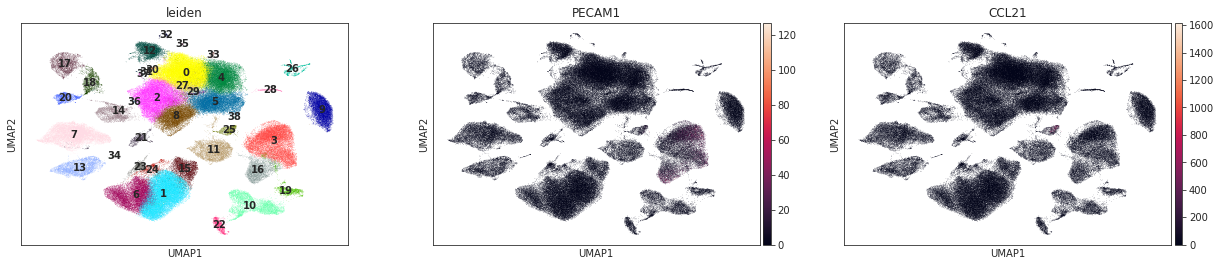

In [3]:
sc.pl.umap(adata, color=['leiden', 'PECAM1', 'CCL21'], legend_loc='on data')

In [5]:
adata = adata[adata.obs.doublet_score<0.2]
adata = adata[adata.obs.percent_mito<0.1]

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [6]:
adata = adata[adata.obs.leiden.isin(["3", '16', '25'])]

In [7]:
A = sc.AnnData(adata.X, var=adata.var, obs=adata.obs)
A.raw = A
# del adata
# gc.collect()

07/21/2022 08:37:12 PM annotating QC
07/21/2022 08:37:15 PM annotating and filtering for coding genes
/home/mstrasse/miniconda3/lib/python3.7/site-packages/sctools/annotations.py:54: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
07/21/2022 08:37:18 PM filtering cells for UMI content
07/21/2022 08:37:18 PM Cells: 15255 -> 15255
07/21/2022 08:37:18 PM filtering cells for mito content
07/21/2022 08:37:19 PM Cells: 15255 -> 15255
07/21/2022 08:37:19 PM Annotating Cell cycle
07/21/2022 08:37:19 PM calculating cell cycle phase
07/21/2022 08:37:19 PM computing score 'S_score'
07/21/2022 08:37:20 PM computing score 'G2M_score'
07/21/2022 08:37:20 PM     'phase', cell cycle phase (adata.obs)
07/21/2022 08:37:20 PM Done: Annotating Cell cycle
07/21/2022 08:37:20 PM Zheng recipe
/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version

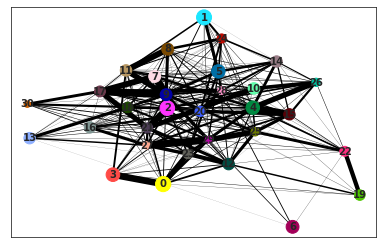

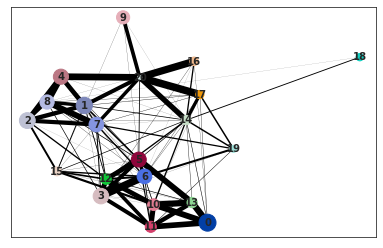

In [8]:
A = pipeline.michi_kallisto_recipe(A,  harmony_correction='samplename')
pipeline.differential_expression_michi_kallisto_recipe(A, 'leiden')

In [9]:
# A.write_h5ad('/home/mstrasse/TB4/cellTypeProportions/endo_processed.h5ad')

# Analysis

In [3]:
A = sc.read_h5ad('/home/mstrasse/TB4/cellTypeProportions/endo_processed.h5ad')
# fixing some diagnosis
A = fix_diagnosis(A)
A.obs.diagnosis = pd.Categorical(A.obs.diagnosis)
recolor(A, 'diagnosis', color_dict_diagnosis)

df_meta = read_metadata()

# again fix diagnosis in those samples
df_meta = df_meta[df_meta.samplename.isin(A.obs.samplename.unique())].set_index('samplename').sort_values('diagnosis')
for s, d in diagnosis_fix_dict.items():
    df_meta.loc[s, 'diagnosis'] = d

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


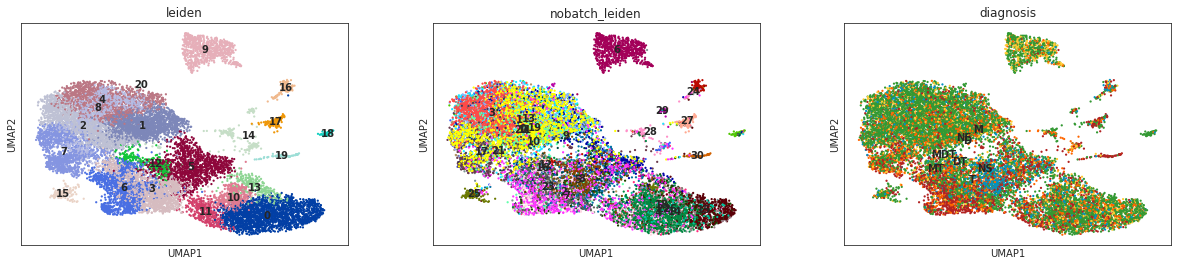

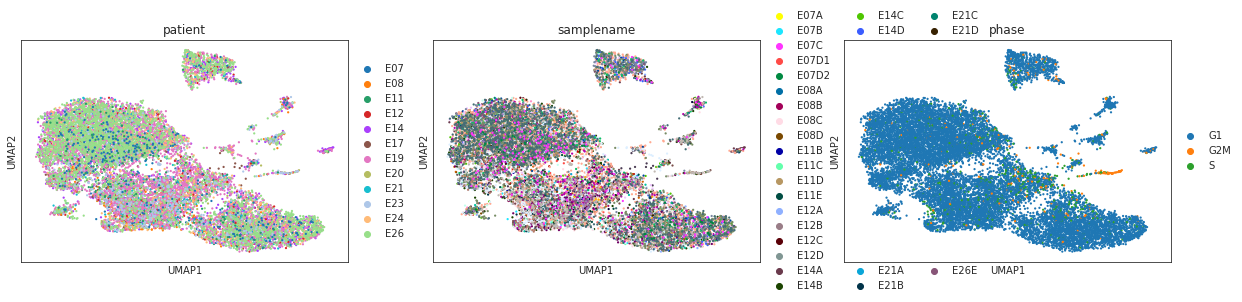

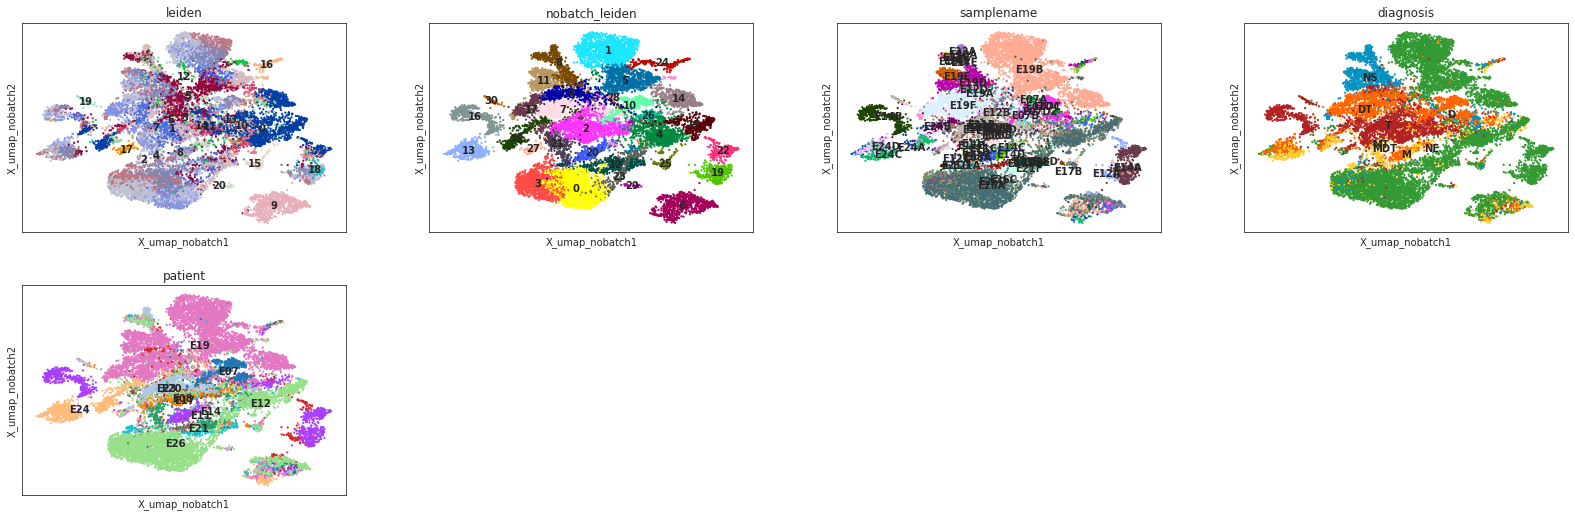

In [4]:
sc.pl.umap(A, color=['leiden', 'nobatch_leiden', 'diagnosis'], legend_loc='on data', size=20)
sc.pl.umap(A, color=['patient', 'samplename', 'phase'], size=20)

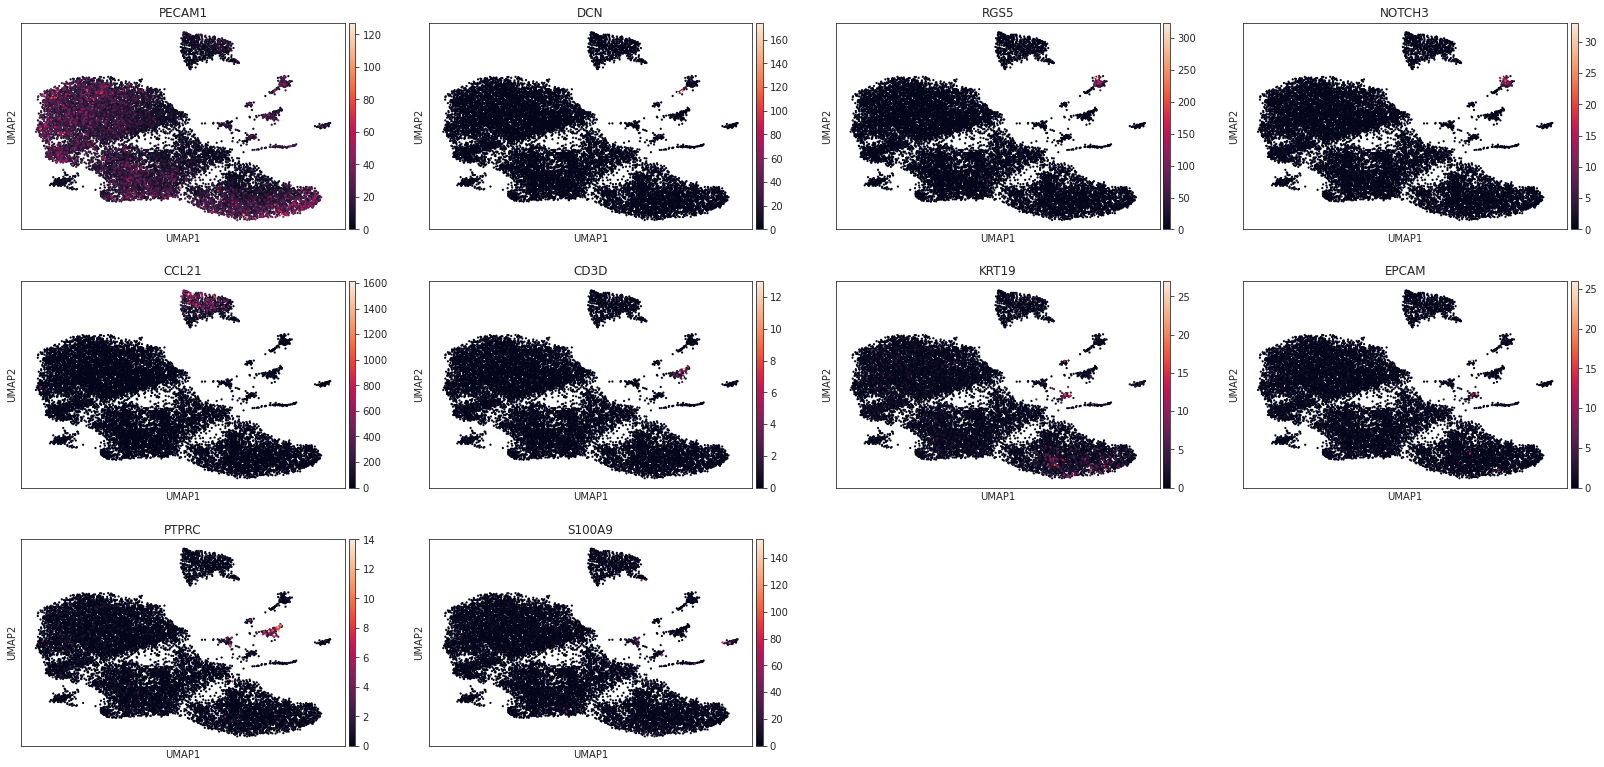

In [8]:
sc.pl.umap(A, color=['PECAM1','DCN', 'RGS5', 'NOTCH3', 'CCL21', 'CD3D', 'KRT19', 'EPCAM', 'PTPRC', 'S100A9'], legend_loc='on data', size=20)

In [5]:
doublets = [
    '16', '17', '20', '18', '14','15'
]

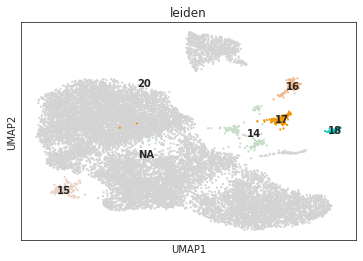

In [6]:
sc.pl.umap(A, color=['leiden'], size=20, legend_loc='on data', groups=doublets)

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


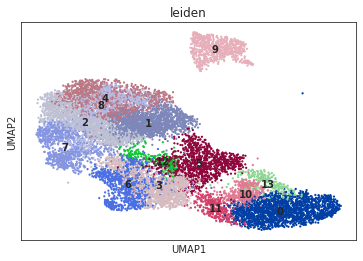

In [7]:
A = A[~A.obs.leiden.isin(doublets)]

# remove the non-pure diagnoses
A = A[A.obs.diagnosis.isin(['NE', 'NS', 'M','D','T'])]

# remove dividing
A = A[~A.obs.leiden.isin(['19'])]

sc.pl.umap(A, color=['leiden'], legend_loc='on data', size=20)

## Coarser recluster

In [8]:
if 'leiden_backup' not in A.obs.columns:
    A.obs['leiden_backup'] = A.obs.leiden
sc.tl.leiden(A, resolution=0.8)
pipeline.differential_expression_michi_kallisto_recipe(A, groupby='leiden')

Trying to set attribute `.obs` of view, copying.
11/22/2022 06:49:11 AM doing csr->csc
11/22/2022 06:49:12 AM done csr->csc
11/22/2022 06:49:39 AM doing csc->csr
11/22/2022 06:49:41 AM done csc->csr
11/22/2022 06:49:41 AM Filtering DE
11/22/2022 06:49:42 AM Done Filtering DE


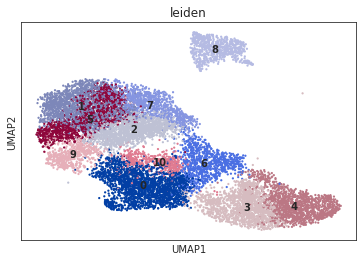

In [9]:
sc.pl.umap(A, color=['leiden'], legend_loc='on data', size=20)

# SCCODA

In [3]:
plotfolder = '/tmp/proportions/Endothelial_proportions/'
import os 
if not os.path.exists(plotfolder):
    os.mkdir(plotfolder)

In [6]:
A = sc.read_h5ad('/home/mstrasse/TB4/cellTypeProportions/scCODA_ready/endo_processed.h5ad')
from crukiopy_release.datatools import fix_diagnosis, diagnosis_fix_dict
A = fix_diagnosis(A)
A.obs.diagnosis = pd.Categorical(A.obs.diagnosis)
recolor(A, 'diagnosis', color_dict_diagnosis)

df_meta = read_metadata()

# again fix diagnosis in those samples
df_meta = df_meta[df_meta.samplename.isin(A.obs.samplename.unique())].set_index('samplename').sort_values('diagnosis')
for s, d in diagnosis_fix_dict.items():
    df_meta.loc[s, 'diagnosis'] = d

In [7]:
data_scanpy_1 = dat.from_scanpy(
    A,
    cell_type_identifier="leiden",
    sample_identifier="samplename",
    covariate_df=df_meta[df_meta.index.isin(A.obs.samplename.unique())]
)
print(data_scanpy_1)

AnnData object with n_obs × n_vars = 49 × 11
    obs: 'foldername', 'patient', 'sequencer', 'tissue', 'flowcell', 'procedure', 'diagnosis', 'treatment', 'phantompurger_folder', 'cruk_sample', 'atlas_sample', 'R2length', 'gender'
    var: 'n_cells'


In [8]:
# cluster_order = A.obs.leiden.cat.categories
cluster_order = [
    '3','4', # arterial
    '0','6','10', # ven
    '9','2','7','5','1', # cap
    '8' # lymph
]

In [9]:
diagnosis_ordered = ['NE', 'M','D','T', 'NS']

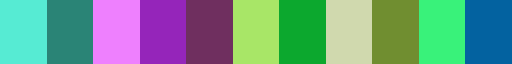

In [10]:
# reorder a little,
from matplotlib.colors import ListedColormap
from crukiopy_release.colormaps import cmap_subtypes
_cm_colors= cmap_subtypes.colors
_cm_colors = np.array(_cm_colors)[[0,1, 
                                   10,11,12,
                                  2,3,4,5,6, 7
                                  ]]
cmap_subtypes = ListedColormap(
    _cm_colors
)
cmap_subtypes

In [11]:
leiden_color_dict = dict(zip(cluster_order, cmap_subtypes.colors ))
_tmp = [leiden_color_dict[c] for c in A.obs.leiden.cat.categories]

if not 'leiden_colors_backup' in A.uns:
    A.uns['leiden_colors_backup']= A.uns['leiden_colors']
A.uns['leiden_colors'] = _tmp

### Saving the adata to disc for later use!!
mkdir /home/mstrasse/TB4/cellTypeProportions/scCODA_ready

In [12]:
# # note: need to write the full 35k genes! .to_adata() neatly pulls that out of .raw and applies any other attributes from teh original adata
# B = A.raw.to_adata()
# B.uns = A.uns
# B.obsm = A.obsm
# B.obsp= A.obsp
# B.write_h5ad('/home/mstrasse/TB4/cellTypeProportions/scCODA_ready/endo_processed.h5ad')

## Proportions

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'sample_diagnosis' as categorical


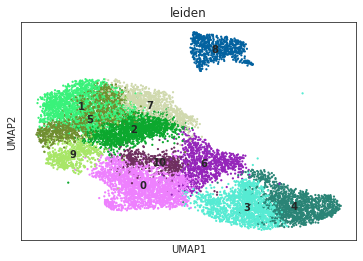

In [13]:
set_matplotlib_formats('png')
sc.pl.umap(A, color=['leiden'], legend_loc='on data', size=20)

In [14]:
set_matplotlib_formats('png')

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


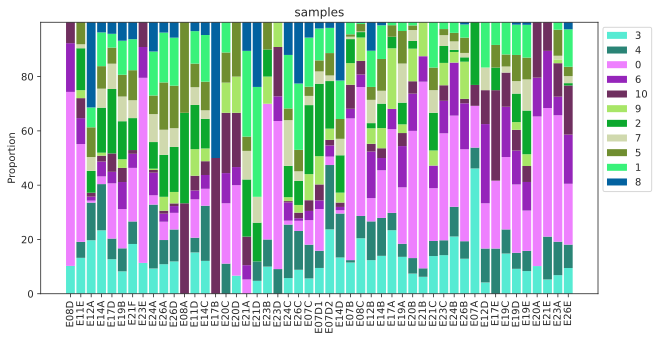

In [15]:
order = []
_s = data_scanpy_1.obs.index
for d in diagnosis_ordered:
    order.extend(sorted(df_meta.query('diagnosis==@d and samplename in @_s').index))

set_matplotlib_formats('svg')
fig = viz.stacked_barplot(data_scanpy_1[:, cluster_order], feature_name="samples", figsize=(10,5), level_order=order, cmap=cmap_subtypes)
plt.xticks(rotation=90);
fig.figure.savefig(f'{plotfolder}/Endothelial_proportions_per_sample.svg')

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


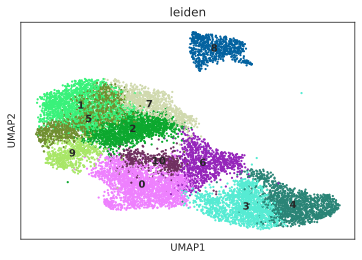

In [19]:
set_matplotlib_formats('svg')
sc.pl.umap(A, color=['leiden'], legend_loc='on data', size=20, show=False)
plt.savefig(f'{plotfolder}/Endothelial_umap.svg')
plt.savefig(f'{plotfolder}/Endothelial_umap.png')
set_matplotlib_formats('png')

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


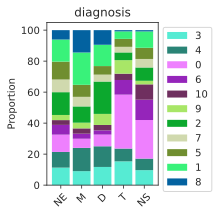

In [20]:
set_matplotlib_formats('svg')
fig = viz.stacked_barplot(data_scanpy_1[:, cluster_order], feature_name="diagnosis", level_order=diagnosis_ordered, cmap=cmap_subtypes, figsize=(2,3))
fig.figure.savefig(f'{plotfolder}/Endothelial_proportions_per_diagnosis.svg')
set_matplotlib_formats('png')

In [24]:
set_matplotlib_formats('png')

In [21]:
q = pd.crosstab(
    pd.Series(pd.Categorical(A.obs.leiden, categories=cluster_order), name='leiden', index=A.obs.leiden.index),
    A.obs.diagnosis
)
norm_freqs = q.div( q.sum(1), axis=0)
norm_freqs = norm_freqs.unstack().reset_index().rename({0:'frequency'}, axis=1)
norm_freqs.diagnosis = pd.Categorical(norm_freqs.diagnosis, categories=diagnosis_ordered)

/home/mstrasse/miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 3 x 2 in image.
/home/mstrasse/miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /tmp/proportions/Endothelial_proportions//Endothelial_proportions_per_cluster.svg


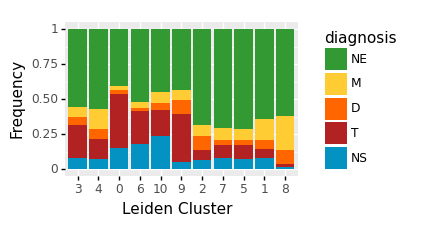

<ggplot: (8775032045429)>

In [23]:
set_matplotlib_formats('svg')
p=pn.ggplot(
    norm_freqs,
    pn.aes(x='leiden', y='frequency', fill='diagnosis')) + pn.geom_bar(stat='identity') \
+ pn.theme(figure_size=(3,2)) + pn.scale_fill_manual(color_dict_diagnosis) + pn.labs(x='Leiden Cluster', y='Frequency')
p.save(f'{plotfolder}/Endothelial_proportions_per_cluster.svg')
set_matplotlib_formats('png')
p

In [24]:
set_matplotlib_formats('png')

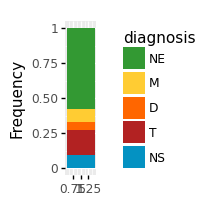

<ggplot: (8752224958057)>

In [31]:
overall_props = A.obs.diagnosis.value_counts()
overall_props = overall_props/overall_props.sum()
overall_props = overall_props.loc[diagnosis_ordered]

_ddd = pd.DataFrame(overall_props).reset_index().rename({'index': 'diagnosis','diagnosis': 'frequency'}, axis=1)
_ddd.diagnosis = pd.Categorical(_ddd.diagnosis, categories=diagnosis_ordered)

pn.ggplot(
    _ddd,
    pn.aes(x=1, y='frequency', fill='diagnosis')) + pn.geom_bar(stat='identity') \
+ pn.theme(figure_size=(7,2)) + pn.scale_fill_manual(color_dict_diagnosis) + pn.theme(figure_size=(0.4,2)) + pn.labs(x='', y='Frequency')

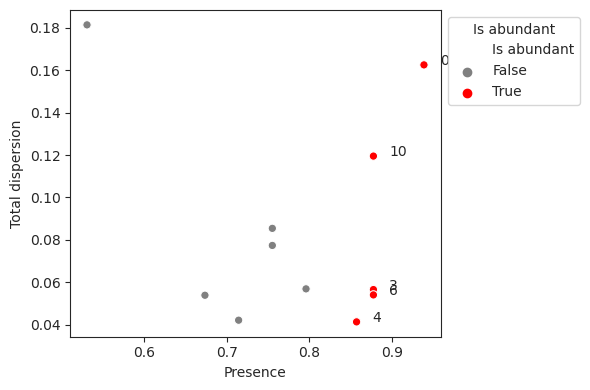

In [104]:
viz.rel_abundance_dispersion_plot(
    data=data_scanpy_1,
    abundant_threshold=0.8)
plt.show()

In [105]:
model_salm = mod.CompositionalAnalysis(data_scanpy_1, formula="C(diagnosis, Treatment('NE')) + procedure + patient", reference_cell_type="4")
# Run MCMC
sim_results = model_salm.sample_hmc(num_results=3*20000)

Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 60000/60000 [08:48<00:00, 113.45it/s]


MCMC sampling finished. (575.274 sec)
Acceptance rate: 47.6%


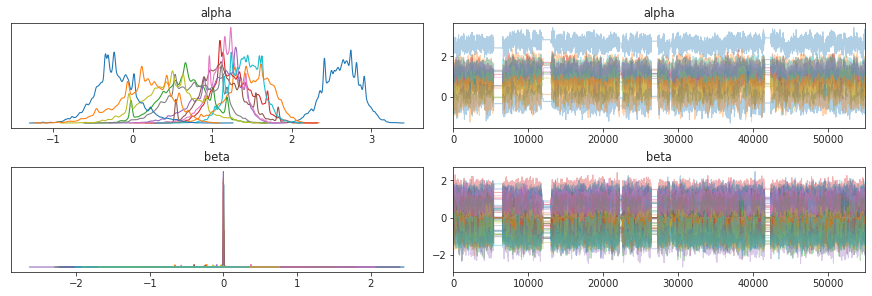

In [53]:
import arviz as az

az.plot_trace(
    sim_results,
    divergences=False,
    var_names=["alpha", "beta"],
    coords={"cell_type": sim_results.posterior.coords["cell_type_nb"]},
)
plt.show()

In [106]:
scCODA_result = sim_results.effect_df
scCODA_result[sim_results.effect_df['Final Parameter'] != 0]

Final Parameter  HDI 3%  \
Covariate                           Cell Type                            
C(diagnosis, Treatment('NE'))[T.M]  1                 0.612790   0.159   
                                    8                 0.570937  -0.016   
C(diagnosis, Treatment('NE'))[T.NS] 0                 1.075428   0.702   
                                    2                -0.707751  -1.242   
                                    6                 1.078083   0.594   
                                    8                -0.791936  -1.498   
                                    10                1.277229   0.834   
C(diagnosis, Treatment('NE'))[T.T]  0                 0.996737   0.549   
                                    2                -0.670629  -1.194   
                                    6                 0.771266   0.248   
                                    8                -1.037883  -1.683   
                                    9                 1.181676   0.657   
procedure[T.resection]              0                -1.338925  -1.737   
                                    1                 1.005633   0.497   
                                    9                -0.749067  -1.256   
                                    10               -1.071725  -1.488   

                                               HDI 97%     SD  \
Covariate                           Cell Type                   
C(diagnosis, Treatment('NE'))[T.M]  1            1.061  0.282   
                                    8            1.161  0.362   
C(diagnosis, Treatment('NE'))[T.NS] 0            1.536  0.225   
                                    2            0.015  0.408   
                                    6            1.569  0.273   
                                    8           -0.116  0.421   
                                    10           1.756  0.246   
C(diagnosis, Treatment('NE'))[T.T]  0            1.407  0.226   
                                    2           -0.115  0.344   
                                    6            1.229  0.306   
                                    8           -0.384  0.383   
                                    9            1.688  0.274   
procedure[T.resection]              0           -0.960  0.200   
                                    1            1.458  0.263   
                                    9           -0.297  0.290   
                                    10          -0.609  0.240   

                                               Inclusion probability  \
Covariate                           Cell Type                          
C(diagnosis, Treatment('NE'))[T.M]  1                       0.938291   
                                    8                       0.832109   
C(diagnosis, Treatment('NE'))[T.NS] 0                       0.998618   
                                    2                       0.839000   
                                    6                       0.995491   
                                    8                       0.880091   
                                    10                      1.000000   
C(diagnosis, Treatment('NE'))[T.T]  0                       1.000000   
                                    2                       0.864436   
                                    6                       0.947218   
                                    8                       0.971255   
                                    9                       1.000000   
procedure[T.resection]              0                       1.000000   
                                    1                       1.000000   
                                    9                       0.958873   
                                    10                      0.995909   

                                               Expected Sample  \
Covariate                           Cell Type                    
C(diagnosis, Treatment('NE'))[T.M]  1                18.027224   
                                    8           

In [107]:
_q = scCODA_result.reset_index()
a = pd.crosstab(_q['Covariate'].replace({
    "C(diagnosis, Treatment('NE'))[T.D]": 'D',
    "C(diagnosis, Treatment('NE'))[T.M]": 'M',
    "C(diagnosis, Treatment('NE'))[T.T]": 'T',
    "C(diagnosis, Treatment('NE'))[T.NS]": 'NS',
    "procedure[T.resection]": 'resection'
    }),
    _q['Cell Type'], 
    values=_q['log2-fold change']* (_q['Final Parameter'] !=0), aggfunc=np.mean).replace({np.nan: 0})


Text(6.0, 0.5, '')

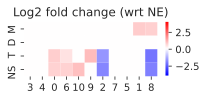

In [119]:
set_matplotlib_formats('svg')
fig, ax = plt.subplots(figsize=(3, 1))
sns.heatmap(a.loc[['M','D','T','NS'], cluster_order], cmap=plt.cm.bwr, vmin=-4, vmax=4)
plt.title('Log2 fold change (wrt NE)')
plt.xlabel(None)
plt.ylabel(None)

In [ ]:
fig.savefig(f'{plotfolder}/Endothelial_scCODA.svg')

In [120]:
set_matplotlib_formats('png')

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


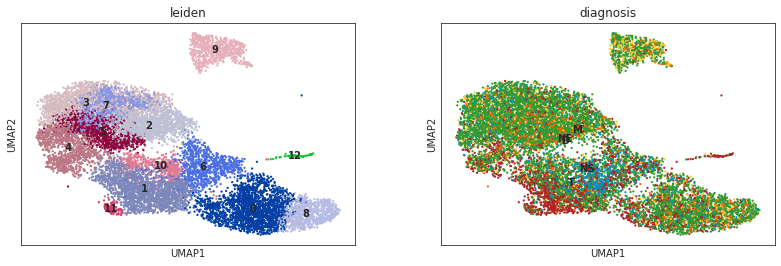

In [57]:
sc.pl.umap(A, color=['leiden', 'diagnosis'], legend_loc='on data', size=20)

# markers

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


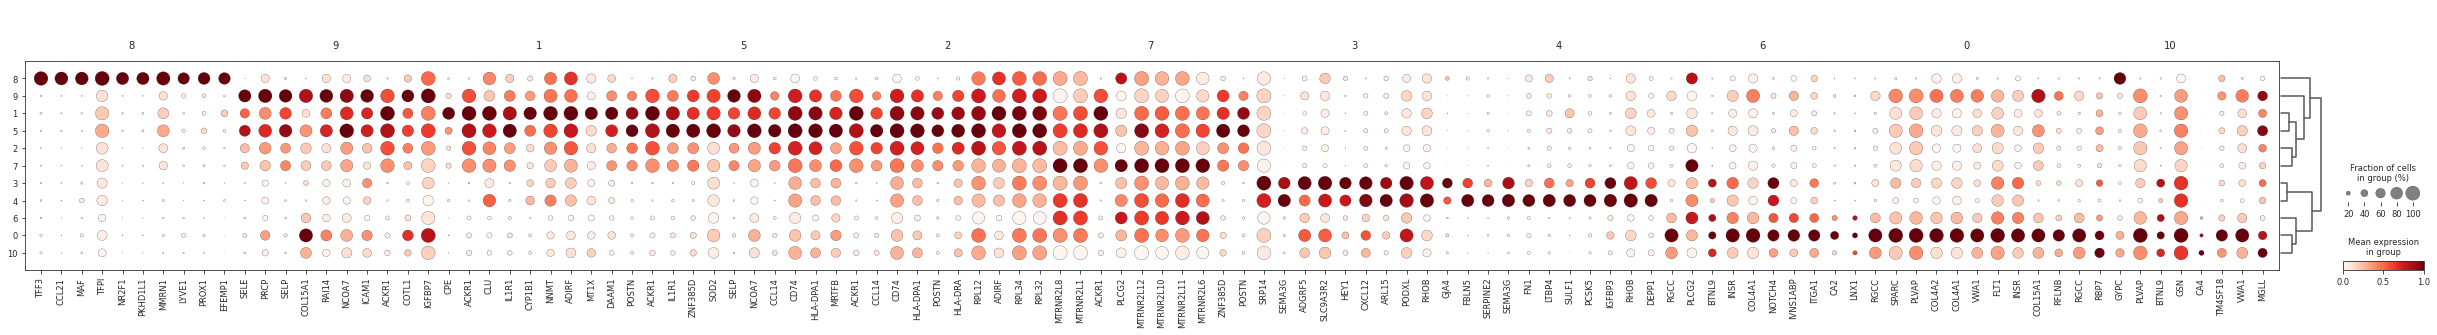

In [29]:
sc.tl.dendrogram(A, groupby='leiden')
sc.pl.rank_genes_groups_dotplot(A, standard_scale='var')

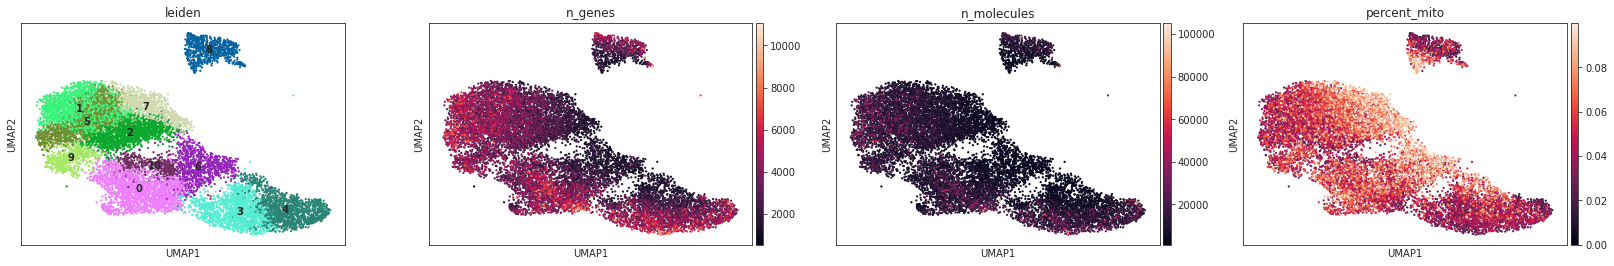

In [35]:
sc.pl.umap(A, color=['leiden', 'n_genes','n_molecules', 'percent_mito'], legend_loc='on data', size=20)

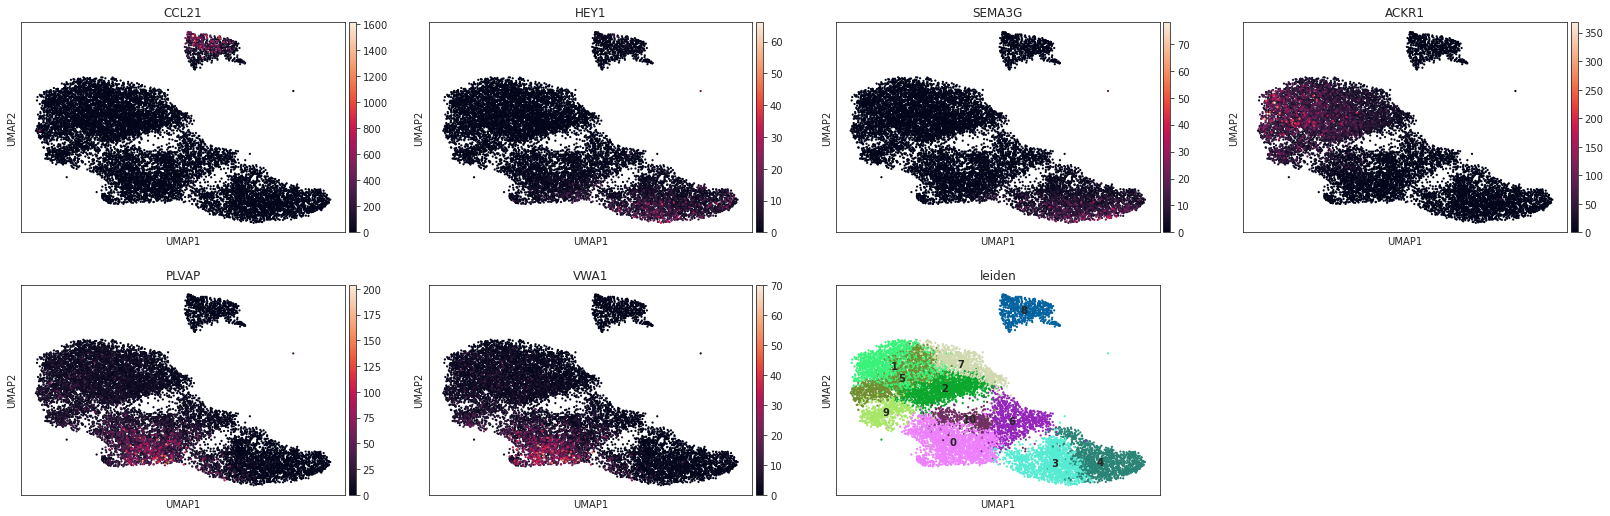

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


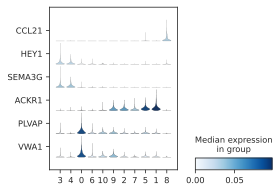

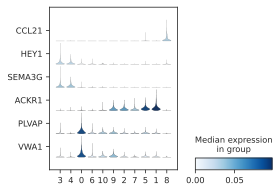

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


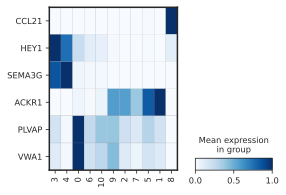

In [30]:
genes =['CCL21','HEY1', 'SEMA3G', 'ACKR1', 'PLVAP', 'VWA1']
set_matplotlib_formats('png')
sc.pl.umap(A, color=genes+['leiden'], legend_loc='on data', size=20)

B = A.copy()
B.obs['leiden'] = pd.Categorical(B.obs['leiden'], categories=cluster_order)
set_matplotlib_formats('svg')
sc.pl.stacked_violin(B, var_names=genes, groupby='leiden', standard_scale='var', swap_axes=True,show=False, #order=cluster_order
                figsize=(4,3))
plt.savefig(f'{plotfolder}/Endothelial_markers.svg')

sc.pl.stacked_violin(B, var_names=genes, groupby='leiden', standard_scale='var', swap_axes=True, use_raw=False,  #order=cluster_order
                figsize=(4,3))

sc.pl.matrixplot(B, var_names=genes, groupby='leiden', standard_scale='var', swap_axes=True, show=False, #order=cluster_order
                figsize=(4,3), cmap='Blues')
plt.savefig(f'{plotfolder}/Endothelial_markers_matrix.svg')